# in this implemetation we will try to examine the effect of weighted KNN and 
# try to explore different values of K and their impact on the accuracy score

In [4]:
#loading the train data
import numpy as np
from numpy import genfromtxt
from tqdm import tqdm
import time
my_data = genfromtxt('trainingData.csv', delimiter=',')

#upon loading we found that the data has total 11 cols starting from 1 as the 1st col
#or you can say 10 cols starting from 0 as the 1st col
y_train=my_data[:,10]# this prints the labels
x_train=my_data[:,:-1] #every row except the last row until last col

#for test data
from numpy import genfromtxt
my_data = genfromtxt('testData.csv', delimiter=',')
y_test=my_data[:,10]
x_test=my_data[:,:-1]

In [5]:
#before we begin lets import some of the important functions that we made in the part 1 and use them here

def d1_euc_dist(list1,list2):
    import numpy as np
    if (len(list1)==len(list2)):
        print("\n")
        #print("elements are of equal length, euc dist can be calculated")
    else:
        print("length of paths is not equal")
        return
    diff=(list1-list2)
    power=np.power(diff,2)
    total=np.sum(power)
    result=np.sqrt(total)
    return result

def mink_dist(list1,list2,p):
    """takes a 2d matrix and another 2d matrix and computes a result of distances
    this computes the value of the power p as the minkowski dist"""
    if (list1.shape!=list2.shape):
        print("shapes do not match ip1 :{} and ip2: {}".format(list1.shape,list2.shape))
    diff=(list1-list2)
    power=np.power(diff,p)
    total=np.sum(power, axis=1)
    total=total.reshape((power.shape[0], 1))
    distances=np.power(total,(1/p))
    return distances

def calculateDistances(array2d, array1d,p=2):
    """array 2d is my all training points taken for calculation of distance
    array 1d is the query point with which the distance has to be calculated"""
    #lets broadcast this query to all the points in the train 
    shape_arr1=array2d.shape
    #make ones of the same shape as train data is given
    broadcast_shape=np.ones(shape_arr1,dtype=np.int16)*array1d
    #now calculate the distance between the two arrays
    distances=mink_dist(broadcast_shape,array2d,p)
    #add an index to the distances
    rows=distances.shape[0] #counts froom 0
    index=np.arange(0,rows,1)
    index=index.reshape((index.shape[0], 1))
    #stacking indexes with distances 
    index_dist=np.column_stack((index,distances))
    
    #now sorting the arrays based on 1st axis
    index_dist=index_dist[index_dist[:,1].argsort()]
    """returning the index value of the distance that can be used to look for the vector
    also returning the distance"""
    index=index_dist[:,0]
    #distances=index_dist[:,1]
    #shortest distances on the top
    return index, distances

def accuracy_score(arr1,arr2):
    """compares elements in both the arrays if they are same then its a match oterwise, No match
    return acc_score defined as total matches upon the elements present"""
    #since both of them are col vectors
    #we can take the row size as total number of elements
    total=arr1.shape[0]#row in arr1
    match=0
    for ele1,ele2 in zip(arr1,arr2):
        if(ele1==ele2):
            match+=1
    return match/total


In [6]:
#now if we want our k dynamic we need to make two additional functions 

#slice(K,indexes,distances) >>>> given a k value slices the K nearest distances and returns the sorted distances and indexes

#majority_vote(index)>>>> takes all the indexes values and looks them up in the y_train label and does a majority count
#returns me the class that has the maximum occurance
def slice_k(k,indexes,distances):
    """slices top k elements from index and distances"""
    rows=indexes.shape[0]
    indexes=indexes.reshape(rows,1)
    k_indexes=indexes[:k]#select top k rows
    k_distances=distances[:k]
    return k_indexes, k_distances


def majority_vote(indexes,y_train):
    """computes the majority vote by looking at the labels in y_train at corresponding indexes"""
    unique_elements=np.unique(y_train)# we can have many classes, we might have to use knn for n classes
    #instead of three so with dynamic approach we can reuse this function
    class_count={}
    for element in unique_elements: #make a dictionary of all elements count
        class_count[element]=0
    for ele1 in indexes:
        ele1=int(ele1)
        label=y_train[ele1]
        class_count[label]+=1
    #print(class_count)#this stores the vote count
    maximum = max(class_count.values())
    #print(maximum) #this is the maximum value in dictionary lets try to look where is this max value
    #note if two classes have same number of votes this will return the first class of occurance
    for key, value in class_count.items():
        if(value==maximum):
            label=key
            break
    #print(label)
    return label
    
for k in range(1,4):
    y_test_predicted=[]
    print("="*50)
    print("knn calculating..... for k= {}".format(k))

    for element in tqdm(x_test):
        indexes,distances=calculateDistances(x_train, element)
        #print(distances.shape)
        indexes,distances=slice_k(k,indexes,distances)
        label=majority_vote(indexes,y_train)
        y_test_predicted.append(label)

    y_test_predicted=np.asarray(y_test_predicted)##y_predicted is my predictions

    acc=accuracy_score(y_test,y_test_predicted)*100
    print("the accuracy value is :{}".format(acc))
    print("="*50)
    print("\n")

 12%|█▏        | 123/1000 [00:00<00:01, 614.12it/s]

knn calculating..... for k= 1


  6%|▋         | 63/1000 [00:00<00:01, 628.59it/s]

the accuracy value is :89.5


knn calculating..... for k= 2


  6%|▋         | 64/1000 [00:00<00:01, 639.85it/s]

the accuracy value is :89.2


knn calculating..... for k= 3


100%|██████████| 1000/1000 [00:01<00:00, 660.72it/s]

the accuracy value is :91.0




# In the above example we saw that accuracy is subjective to the k value, so which K value to choose?

We will pick that value of K that maximizes accuracy.
relying on more than 1 neighbour was a good decision as this makes my model robust and label takes a value based on majority vote from nearest neighbours.

but there are two problems taking the maximum accuracy K

1- accuracy fails when data is imbalanced- suppose I have 90% points classified as class "A" and only 10% points saying class "B" then even a very Naive model that flags every point as class "A" will have a 90% accuracy, hence accuracy does not hold any meaning in imbalanced datasets.

2- problem of easily overfitting- this is another drawback of imbalanced datasets when the K value is very high, suppose k=total points then no matter which query I will give I will always decide the output as majority class i.e class "A" even when the query very close to the other class "B" selecting a bigger size of K makes model makes decision biased towards class "A" or simply overfitting

solution 1- since we cannot rely on other evaluation metrics for this problem, I will set my benchmark as the model that always predicts the majority class in the dataset and then we will see what would be the accuracy of the model that always outputs the majority class  

solution 2- we can draw a k vs accuracy graph and where ever we see that the accuracy is increased we will take that.
(If there are two K values that give the same accuracy then I will take the greater of the two ,Why ?
because when I take greater K value I am immune to noise{outliers} as I am relying my trust on more number of neighbours instead of a very small size)

There are other problems with KNN which will be explained in the pdf 


In [7]:
#now lets work on solution 1
unique_labels=np.unique(y_train) #contains a list of all unique labels 
class_count={}
for element in unique_labels: #make a dictionary of all unique labels and set the count 0
    class_count[element]=0
for ele1 in y_train:
    for label in unique_labels:
        if(label==ele1):
            class_count[label]+=1
            
print(class_count)            
print(max(class_count.values()))
baseline=(max(class_count.values())/sum(class_count.values()))*100
print("the baseline accuracy would be :{}".format(baseline))
#as we found in our analysis that the data is pretty balanced, hence we dont need worry for this problem
#if I output majority class in balanced data it doesnot matter as the max accuracy I can get is 33.55%
#and the accuracy that I am getting is way more than baseline
#so this problem is already taken care of 

{0.0: 1317, 1.0: 1341, 2.0: 1342}
1342
the baseline accuracy would be :33.550000000000004


# you can turn of the below code as it can take alot of time depending upon the processor inside your laptop it shows what happens when my K value is equal to the number of data points

In [8]:
#this is a highly unpractical way of looking at all the k values so inorder to avoid excessive training time
#we will not train our model for this long, we usually will train uptill 30 kNN values
tic=time.time()
k_ranges=[]
accuracy_ranges=[]
for k in range(1,31):
    y_test_predicted=[]
    print("="*50)
    print("knn calculating..... for k= {}".format(k))

    for element in tqdm(x_test):
        indexes,distances=calculateDistances(x_train, element)
        #print(distances.shape)
        indexes,distances=slice_k(k,indexes,distances)
        label=majority_vote(indexes,y_train)
        y_test_predicted.append(label)

    y_test_predicted=np.asarray(y_test_predicted)##y_predicted is my predictions

    acc=accuracy_score(y_test,y_test_predicted)*100
    print("the accuracy value is :{}".format(acc))
    print("="*50)
    print("\n")
    k_ranges.append(k)
    accuracy_ranges.append(acc)
    
toc=time.time()    
knn_time=toc-tic
print("total time:{}".format(knn_time))


  6%|▌         | 62/1000 [00:00<00:01, 615.15it/s]

knn calculating..... for k= 1


  6%|▋         | 65/1000 [00:00<00:01, 639.42it/s]

the accuracy value is :89.5


knn calculating..... for k= 2


  7%|▋         | 66/1000 [00:00<00:01, 648.69it/s]

the accuracy value is :89.2


knn calculating..... for k= 3


  7%|▋         | 67/1000 [00:00<00:01, 666.80it/s]

the accuracy value is :91.0


knn calculating..... for k= 4


  6%|▋         | 64/1000 [00:00<00:01, 630.85it/s]

the accuracy value is :92.0


knn calculating..... for k= 5


  6%|▋         | 64/1000 [00:00<00:01, 636.40it/s]

the accuracy value is :92.4


knn calculating..... for k= 6


  6%|▌         | 59/1000 [00:00<00:01, 585.10it/s]

the accuracy value is :92.30000000000001


knn calculating..... for k= 7


  6%|▌         | 61/1000 [00:00<00:01, 602.48it/s]

the accuracy value is :92.2


knn calculating..... for k= 8


  6%|▌         | 62/1000 [00:00<00:01, 616.15it/s]

the accuracy value is :91.8


knn calculating..... for k= 9


  7%|▋         | 67/1000 [00:00<00:01, 660.42it/s]

the accuracy value is :92.80000000000001


knn calculating..... for k= 10


 13%|█▎        | 127/1000 [00:00<00:01, 625.32it/s]

the accuracy value is :92.2


knn calculating..... for k= 11


  7%|▋         | 68/1000 [00:00<00:01, 674.13it/s]

the accuracy value is :91.8


knn calculating..... for k= 12


 12%|█▏        | 120/1000 [00:00<00:01, 591.46it/s]

the accuracy value is :92.0


knn calculating..... for k= 13


  7%|▋         | 68/1000 [00:00<00:01, 677.49it/s]

the accuracy value is :91.9


knn calculating..... for k= 14


  6%|▋         | 63/1000 [00:00<00:01, 618.78it/s]

the accuracy value is :92.4


knn calculating..... for k= 15


  6%|▌         | 60/1000 [00:00<00:01, 592.29it/s]

the accuracy value is :92.4


knn calculating..... for k= 16


  7%|▋         | 68/1000 [00:00<00:01, 676.88it/s]

the accuracy value is :92.0


knn calculating..... for k= 17


  6%|▌         | 62/1000 [00:00<00:01, 611.83it/s]

the accuracy value is :91.7


knn calculating..... for k= 18


  6%|▋         | 63/1000 [00:00<00:01, 623.23it/s]

the accuracy value is :91.9


knn calculating..... for k= 19


  7%|▋         | 69/1000 [00:00<00:01, 685.58it/s]

the accuracy value is :91.7


knn calculating..... for k= 20


  6%|▌         | 62/1000 [00:00<00:01, 615.85it/s]

the accuracy value is :91.4


knn calculating..... for k= 21


  7%|▋         | 68/1000 [00:00<00:01, 674.64it/s]

the accuracy value is :91.4


knn calculating..... for k= 22


  7%|▋         | 68/1000 [00:00<00:01, 677.80it/s]

the accuracy value is :91.60000000000001


knn calculating..... for k= 23


  7%|▋         | 67/1000 [00:00<00:01, 660.56it/s]

the accuracy value is :91.3


knn calculating..... for k= 24


  7%|▋         | 68/1000 [00:00<00:01, 675.32it/s]

the accuracy value is :90.8


knn calculating..... for k= 25


  7%|▋         | 68/1000 [00:00<00:01, 672.70it/s]

the accuracy value is :90.60000000000001


knn calculating..... for k= 26


 12%|█▏        | 123/1000 [00:00<00:01, 613.79it/s]

the accuracy value is :90.7


knn calculating..... for k= 27


  6%|▌         | 57/1000 [00:00<00:01, 569.25it/s]

the accuracy value is :90.8


knn calculating..... for k= 28


  7%|▋         | 67/1000 [00:00<00:01, 668.57it/s]

the accuracy value is :90.4


knn calculating..... for k= 29


  7%|▋         | 68/1000 [00:00<00:01, 679.37it/s]

the accuracy value is :90.7


knn calculating..... for k= 30


100%|██████████| 1000/1000 [00:01<00:00, 616.65it/s]

the accuracy value is :90.3


total time:47.232909202575684


[89.5, 89.2, 91.0, 92.0, 92.4, 92.30000000000001, 92.2, 91.8, 92.80000000000001, 92.2, 91.8, 92.0, 91.9, 92.4, 92.4, 92.0, 91.7, 91.9, 91.7, 91.4, 91.4, 91.60000000000001, 91.3, 90.8, 90.60000000000001, 90.7, 90.8, 90.4, 90.7, 90.3]


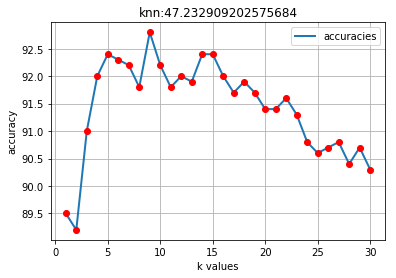

maximum accuracy is 92.80000000000001 at 8th run
the best k value is:9, and the accuracy is 92.80000000000001


In [9]:
print(accuracy_ranges)
#plotting graphs with matplot lib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(k_ranges, accuracy_ranges, linewidth=2)
plt.legend(["accuracies"])
plt.plot(k_ranges, accuracy_ranges, 'ro')
plt.axis('tight')
plt.grid()
plt.xlabel('k values')
plt.ylabel('accuracy')
plt.title("knn:{}".format(knn_time))
plt.show()
ind=accuracy_ranges.index(max(accuracy_ranges))
print("maximum accuracy is {} at {}th run".format(max(accuracy_ranges),ind))
best_k=k_ranges[ind]
print("the best k value is:{}, and the accuracy is {}".format(best_k,accuracy_ranges[ind]))
#there is one problem still here 
#since every point that lies in the neighbourhood has weight values equal to 1 
#meaning the position of the nearest neighbour does not matter as much as it's in the neighbourhood
#what could have been improved over here is if my weights change their value according to the distance 
#meaning lower distance should have higher weight value 
#substitute  the word vote in the above example with these weights, instead now I can calculate the 
#total weight score of each class and whoever has max weight should give better accuracy

In [10]:
#there is one problem still here 
#since every point that lies in the neighbourhood has weight values equal to 1 
#meaning the position of the nearest neighbour does not matter as much as it's in the neighbourhood
#what could have been improved over here is if my weights change their value according to the distance 
#meaning lower distance should have higher weight value 
#substitute  the word vote in the above example with these weights, instead now I can calculate the 
#total weight score of each class and whoever has max weight should give better accuracy
#weighted knn for k=10
def weighted_majority_vote(distances,indexes,y_train,weight_penalty):
    """computes the weighted majority vote and returns a label"""
    row,col=distances.shape
    distances=np.power(distances,weight_penalty)
    values=np.divide(np.ones((row,col)),distances)
    unique_elements=np.unique(y_train)# we can have many classes, we might have to use knn for n classes
    #instead of three so with dynamic approach we can reuse this function
    class_count={}
    for element in unique_elements: #make a dictionary of all elements count
        class_count[element]=0
    #print(class_count)
    i=0
    for ele1 in indexes:
        ele1=int(ele1)
        label=y_train[ele1]
        #print(ele1,label)
        class_count[label]+=float(values[i]) #add the corresponding weight in dictionary
        i+=1
        
    #print(class_count)#this stores the vote count
    maximum = max(class_count.values())
    #print(maximum) #this is the maximum value in dictionary lets try to look where is this max value
    for key, value in class_count.items():
        if(value==maximum):
            label=key
            break
    return label   

import time
tic=time.time()
k_ranges_weight=[]
accuracy_ranges_weight=[]

for k in range(1,31):
    y_test_predicted=[]
    print("="*50)
    print("knn calculating..... for k= {}".format(k))

    for element in tqdm(x_test):
        indexes,distances=calculateDistances(x_train, element)
        #print(distances.shape)
        indexes,distances=slice_k(k,indexes,distances)
        label=weighted_majority_vote(distances,indexes,y_train,1)
        y_test_predicted.append(label)

    y_test_predicted=np.asarray(y_test_predicted)##y_predicted is my predictions

    acc=accuracy_score(y_test,y_test_predicted)*100
    print("the accuracy value is :{}".format(acc))
    print("="*50)
    print("\n") 
    k_ranges_weight.append(k)
    accuracy_ranges_weight.append(acc)

toc=time.time()
weighted_knn_time=toc-tic
print("total time taken by knn is :{}".format(weighted_knn_time))


  6%|▋         | 64/1000 [00:00<00:01, 632.54it/s]

knn calculating..... for k= 1


  6%|▌         | 58/1000 [00:00<00:01, 573.38it/s]

the accuracy value is :89.5


knn calculating..... for k= 2


  6%|▌         | 60/1000 [00:00<00:01, 598.25it/s]

the accuracy value is :89.1


knn calculating..... for k= 3


  6%|▋         | 63/1000 [00:00<00:01, 621.00it/s]

the accuracy value is :91.2


knn calculating..... for k= 4


  7%|▋         | 66/1000 [00:00<00:01, 651.23it/s]

the accuracy value is :91.4


knn calculating..... for k= 5


  6%|▌         | 60/1000 [00:00<00:01, 596.27it/s]

the accuracy value is :92.10000000000001


knn calculating..... for k= 6


 13%|█▎        | 127/1000 [00:00<00:01, 641.32it/s]

the accuracy value is :92.0


knn calculating..... for k= 7


 13%|█▎        | 132/1000 [00:00<00:01, 656.19it/s]

the accuracy value is :91.8


knn calculating..... for k= 8


  7%|▋         | 66/1000 [00:00<00:01, 653.30it/s]

the accuracy value is :91.4


knn calculating..... for k= 9


  6%|▌         | 62/1000 [00:00<00:01, 612.58it/s]

the accuracy value is :92.7


knn calculating..... for k= 10


  7%|▋         | 66/1000 [00:00<00:01, 650.90it/s]

the accuracy value is :91.9


knn calculating..... for k= 11


  6%|▌         | 62/1000 [00:00<00:01, 608.85it/s]

the accuracy value is :92.30000000000001


knn calculating..... for k= 12


  6%|▌         | 61/1000 [00:00<00:01, 602.01it/s]

the accuracy value is :92.30000000000001


knn calculating..... for k= 13


  6%|▌         | 59/1000 [00:00<00:01, 584.08it/s]

the accuracy value is :92.0


knn calculating..... for k= 14


  6%|▌         | 60/1000 [00:00<00:01, 592.79it/s]

the accuracy value is :92.0


knn calculating..... for k= 15


  6%|▌         | 60/1000 [00:00<00:01, 598.91it/s]

the accuracy value is :92.10000000000001


knn calculating..... for k= 16


  6%|▌         | 61/1000 [00:00<00:01, 603.20it/s]

the accuracy value is :91.9


knn calculating..... for k= 17


  6%|▋         | 64/1000 [00:00<00:01, 638.69it/s]

the accuracy value is :91.7


knn calculating..... for k= 18


  6%|▌         | 62/1000 [00:00<00:01, 615.36it/s]

the accuracy value is :91.7


knn calculating..... for k= 19


  6%|▌         | 60/1000 [00:00<00:01, 592.43it/s]

the accuracy value is :91.60000000000001


knn calculating..... for k= 20


 13%|█▎        | 127/1000 [00:00<00:01, 623.34it/s]

the accuracy value is :91.5


knn calculating..... for k= 21


  7%|▋         | 66/1000 [00:00<00:01, 656.33it/s]

the accuracy value is :91.5


knn calculating..... for k= 22


 13%|█▎        | 132/1000 [00:00<00:01, 658.53it/s]

the accuracy value is :91.7


knn calculating..... for k= 23


  6%|▌         | 60/1000 [00:00<00:01, 597.87it/s]

the accuracy value is :91.4


knn calculating..... for k= 24


  6%|▋         | 65/1000 [00:00<00:01, 647.34it/s]

the accuracy value is :90.60000000000001


knn calculating..... for k= 25


 12%|█▏        | 123/1000 [00:00<00:01, 601.53it/s]

the accuracy value is :90.9


knn calculating..... for k= 26


 12%|█▎        | 125/1000 [00:00<00:01, 632.55it/s]

the accuracy value is :90.60000000000001


knn calculating..... for k= 27


 12%|█▎        | 125/1000 [00:00<00:01, 623.31it/s]

the accuracy value is :90.60000000000001


knn calculating..... for k= 28


 13%|█▎        | 129/1000 [00:00<00:01, 646.88it/s]

the accuracy value is :90.5


knn calculating..... for k= 29


 12%|█▏        | 124/1000 [00:00<00:01, 597.77it/s]

the accuracy value is :90.4


knn calculating..... for k= 30


100%|██████████| 1000/1000 [00:01<00:00, 635.27it/s]

the accuracy value is :89.7


total time taken by knn is :48.41345000267029


[89.5, 89.1, 91.2, 91.4, 92.10000000000001, 92.0, 91.8, 91.4, 92.7, 91.9, 92.30000000000001, 92.30000000000001, 92.0, 92.0, 92.10000000000001, 91.9, 91.7, 91.7, 91.60000000000001, 91.5, 91.5, 91.7, 91.4, 90.60000000000001, 90.9, 90.60000000000001, 90.60000000000001, 90.5, 90.4, 89.7]


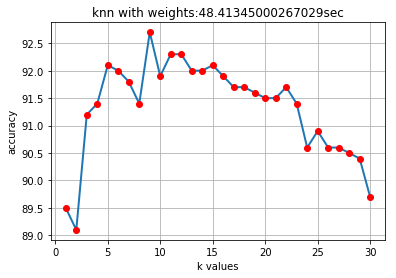

maximum accuracy is 92.7 at 8th run
the best k value is:9, and the accuracy is 92.7


In [11]:
print(accuracy_ranges_weight)
#plotting graphs with matplot lib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(k_ranges_weight, accuracy_ranges_weight, linewidth=2)
plt.plot(k_ranges_weight, accuracy_ranges_weight, 'ro')
plt.axis('tight')
plt.grid()
plt.xlabel('k values')
plt.ylabel('accuracy')
plt.title("knn with weights:{}sec".format(weighted_knn_time))
plt.show()
ind=accuracy_ranges_weight.index(max(accuracy_ranges_weight))
print("maximum accuracy is {} at {}th run".format(max(accuracy_ranges_weight),ind))
best_k_weight=k_ranges_weight[ind]
print("the best k value is:{}, and the accuracy is {}".format(best_k_weight,accuracy_ranges_weight[ind]))

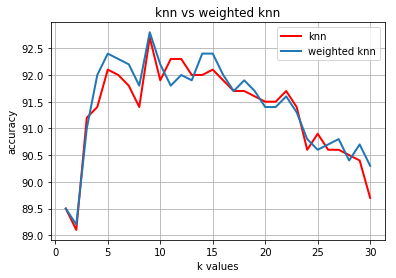

In [12]:
#comparison of both knn approaches
#plotting graphs with matplot lib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(k_ranges_weight, accuracy_ranges_weight,"r-", linewidth=2,label='knn')
plt.plot(k_ranges, accuracy_ranges,linewidth=2,label="weighted knn")
plt.legend(['weighted knn',"knn"])
plt.axis('tight')
plt.grid()
plt.xlabel('k values')
plt.ylabel('accuracy')
plt.title("knn vs weighted knn")
plt.legend()
plt.show()
#there is one problem still here 
#since every point that lies in the neighbourhood has weight values equal to 1 
#meaning the position of the nearest neighbour does not matter as much as it's in the neighbourhood
#what could have been improved over here is if my weights change their value according to the distance 
#meaning lower distance should have higher weight value 
#substitute  the word vote in the above example with these weights, instead now I can calculate the 
#total weight score of each class and whoever has max weight should give better accuracy

# weighted knn for k=10 (as asked in the second part)

In [13]:
#weighted knn for k=10

def weighted_majority_vote(distances,indexes,y_train,weight_penalty):
    """computes the weighted majority vote and returns a label"""
    row,col=distances.shape
    distances=np.power(distances,weight_penalty)
    values=np.divide(np.ones((row,col)),distances)
    unique_elements=np.unique(y_train)# we can have many classes, we might have to use knn for n classes
    #instead of three so with dynamic approach we can reuse this function
    class_count={}
    for element in unique_elements: #make a dictionary of all elements count
        class_count[element]=0
    #print(class_count)
    i=0
    for ele1 in indexes:
        ele1=int(ele1)
        label=y_train[ele1]
        #print(ele1,label)
        class_count[label]+=float(values[i]) #add the corresponding weight in dictionary
        i+=1
        
    #print(class_count)#this stores the vote count
    maximum = max(class_count.values())
    #print(maximum) #this is the maximum value in dictionary lets try to look where is this max value
    for key, value in class_count.items():
        if(value==maximum):
            label=key
            break
    return label  

k=10

y_test_predicted=[]
print("="*50)
print("knn calculating..... for k= {}".format(k))

for element in tqdm(x_test):
    indexes,distances=calculateDistances(x_train, element)
    #print(distances.shape)
    indexes,distances=slice_k(k,indexes,distances)
    label=weighted_majority_vote(distances,indexes,y_train,weight_penalty=1)
    y_test_predicted.append(label)

y_test_predicted=np.asarray(y_test_predicted)##y_predicted is my predictions

acc=accuracy_score(y_test,y_test_predicted)*100
print("the accuracy value is :{}".format(acc))
print("="*50)
print("\n") 



  0%|          | 0/1000 [00:00<?, ?it/s]

knn calculating..... for k= 10


100%|██████████| 1000/1000 [00:01<00:00, 645.73it/s]

the accuracy value is :91.9




# Problem with euclidean distance as measure 

as explained in the pdf we know euclidean measure is not the best measure, as the feature with bigger range dominates the feature with smaller hence we have to use col standardization that equally scales features proportitional and shifting the centre to the origin 

In this demonstration I am allowed to tackle the problem with high level libraries

In [27]:
#upon loading we found that the data has total 11 cols starting from 1 as the 1st col
#or you can say 10 cols starting from 0 as the 1st col
#standardize the data necessary before pca
# Data-preprocessing: Standardizing the data
def normalize_X(x):
    maximum=np.amax(x, axis=0) #col wise max
    minimum=np.amin(x, axis=0) #col wise min
    deno=np.subtract(maximum,abs(minimum))
    x=(x-minimum)/deno
    return x
    

from numpy import genfromtxt
my_data = genfromtxt('trainingData.csv', delimiter=',')

y_train=my_data[:,10]# this prints the labels
x_train=my_data[:,:-1] #every row except the last row until last col
x_train=normalize_X(x_train)


#x_test =normalize_X(x_test)
my_data = genfromtxt('testData.csv', delimiter=',')
y_test=my_data[:,10]
x_test=my_data[:,:-1]
x_test=normalize_X(x_test)



#normal knn
tic=time.time()
k_ranges_std=[]
accuracy_ranges_std=[]
for k in range(1,31):
    y_test_predicted=[]
    print("="*50)
    print("knn calculating..... for k= {}".format(k))

    for element in tqdm(x_test):
        indexes,distances=calculateDistances(x_train, element)
        #print(distances.shape)
        indexes,distances=slice_k(k,indexes,distances)
        label=majority_vote(indexes,y_train)
        y_test_predicted.append(label)

    y_test_predicted=np.asarray(y_test_predicted)##y_predicted is my predictions

    acc=accuracy_score(y_test,y_test_predicted)*100
    print("the accuracy value is :{}".format(acc))
    print("="*50)
    print("\n")
    k_ranges_std.append(k)
    accuracy_ranges_std.append(acc)
toc=time.time() 
print("the exection time on knn after std is :{}".format(toc-tic))


  6%|▋         | 64/1000 [00:00<00:01, 634.73it/s]

knn calculating..... for k= 1


  7%|▋         | 68/1000 [00:00<00:01, 676.43it/s]

the accuracy value is :83.2


knn calculating..... for k= 2


  6%|▋         | 63/1000 [00:00<00:01, 626.15it/s]

the accuracy value is :83.5


knn calculating..... for k= 3


 13%|█▎        | 134/1000 [00:00<00:01, 667.49it/s]

the accuracy value is :83.89999999999999


knn calculating..... for k= 4


  6%|▋         | 63/1000 [00:00<00:01, 629.56it/s]

the accuracy value is :84.1


knn calculating..... for k= 5


  6%|▌         | 60/1000 [00:00<00:01, 590.54it/s]

the accuracy value is :84.0


knn calculating..... for k= 6


  7%|▋         | 68/1000 [00:00<00:01, 670.65it/s]

the accuracy value is :83.89999999999999


knn calculating..... for k= 7


 14%|█▎        | 136/1000 [00:00<00:01, 677.58it/s]

the accuracy value is :83.7


knn calculating..... for k= 8


 14%|█▎        | 136/1000 [00:00<00:01, 677.39it/s]

the accuracy value is :84.89999999999999


knn calculating..... for k= 9


  7%|▋         | 70/1000 [00:00<00:01, 692.40it/s]

the accuracy value is :83.6


knn calculating..... for k= 10


  7%|▋         | 70/1000 [00:00<00:01, 695.20it/s]

the accuracy value is :83.2


knn calculating..... for k= 11


  6%|▋         | 64/1000 [00:00<00:01, 633.87it/s]

the accuracy value is :82.69999999999999


knn calculating..... for k= 12


  7%|▋         | 70/1000 [00:00<00:01, 695.79it/s]

the accuracy value is :82.39999999999999


knn calculating..... for k= 13


  7%|▋         | 70/1000 [00:00<00:01, 694.04it/s]

the accuracy value is :83.5


knn calculating..... for k= 14


 14%|█▍        | 138/1000 [00:00<00:01, 687.91it/s]

the accuracy value is :82.3


knn calculating..... for k= 15


  7%|▋         | 69/1000 [00:00<00:01, 683.53it/s]

the accuracy value is :83.1


knn calculating..... for k= 16


  7%|▋         | 69/1000 [00:00<00:01, 681.58it/s]

the accuracy value is :82.3


knn calculating..... for k= 17


  6%|▋         | 65/1000 [00:00<00:01, 645.13it/s]

the accuracy value is :82.39999999999999


knn calculating..... for k= 18


  7%|▋         | 66/1000 [00:00<00:01, 652.91it/s]

the accuracy value is :82.19999999999999


knn calculating..... for k= 19


  7%|▋         | 69/1000 [00:00<00:01, 687.83it/s]

the accuracy value is :82.0


knn calculating..... for k= 20


  7%|▋         | 69/1000 [00:00<00:01, 681.41it/s]

the accuracy value is :81.89999999999999


knn calculating..... for k= 21


  6%|▋         | 63/1000 [00:00<00:01, 628.99it/s]

the accuracy value is :81.39999999999999


knn calculating..... for k= 22


  7%|▋         | 69/1000 [00:00<00:01, 684.31it/s]

the accuracy value is :82.0


knn calculating..... for k= 23


 13%|█▎        | 132/1000 [00:00<00:01, 663.25it/s]

the accuracy value is :81.39999999999999


knn calculating..... for k= 24


  6%|▋         | 63/1000 [00:00<00:01, 623.68it/s]

the accuracy value is :81.39999999999999


knn calculating..... for k= 25


 14%|█▍        | 138/1000 [00:00<00:01, 686.27it/s]

the accuracy value is :81.5


knn calculating..... for k= 26


 12%|█▏        | 120/1000 [00:00<00:01, 598.04it/s]

the accuracy value is :81.69999999999999


knn calculating..... for k= 27


  7%|▋         | 70/1000 [00:00<00:01, 697.55it/s]

the accuracy value is :81.5


knn calculating..... for k= 28


  6%|▌         | 62/1000 [00:00<00:01, 613.51it/s]

the accuracy value is :81.39999999999999


knn calculating..... for k= 29


  6%|▋         | 63/1000 [00:00<00:01, 622.07it/s]

the accuracy value is :80.9


knn calculating..... for k= 30


100%|██████████| 1000/1000 [00:01<00:00, 603.53it/s]

the accuracy value is :81.10000000000001


the exection time on knn after std is :46.02084302902222


[83.2, 83.5, 83.89999999999999, 84.1, 84.0, 83.89999999999999, 83.7, 84.89999999999999, 83.6, 83.2, 82.69999999999999, 82.39999999999999, 83.5, 82.3, 83.1, 82.3, 82.39999999999999, 82.19999999999999, 82.0, 81.89999999999999, 81.39999999999999, 82.0, 81.39999999999999, 81.39999999999999, 81.5, 81.69999999999999, 81.5, 81.39999999999999, 80.9, 81.10000000000001]


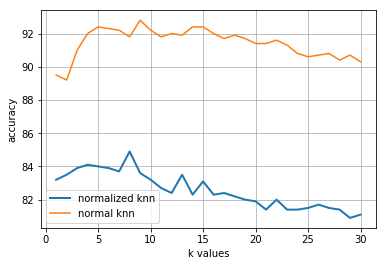

maximum accuracy is 84.89999999999999 at 8th run
the best k value is:9, and the accuracy is 83.6


In [28]:
print(accuracy_ranges_std)
#plotting graphs with matplot lib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(k_ranges_std, accuracy_ranges_std, linewidth=2)
plt.plot(k_ranges, accuracy_ranges)
plt.legend(["normalized knn","normal knn"])
plt.axis('tight')
plt.grid()
plt.xlabel('k values')
plt.ylabel('accuracy')
plt.show()
ind=accuracy_ranges.index(max(accuracy_ranges))
print("maximum accuracy is {} at {}th run".format(max(accuracy_ranges_std),ind))
best_k_std=k_ranges_std[ind]
print("the best k value is:{}, and the accuracy is {}".format(best_k_std,accuracy_ranges_std[ind]))

In the above diagram we see that normalization does not help instead it reduces the accuracy.

  0%|          | 0/1000 [00:00<?, ?it/s]

knn calculating..... for k= 1


 12%|█▏        | 123/1000 [00:00<00:01, 613.91it/s]

the accuracy value is :83.2


knn calculating..... for k= 2


  6%|▌         | 60/1000 [00:00<00:01, 597.50it/s]

the accuracy value is :82.8


knn calculating..... for k= 3


  6%|▌         | 62/1000 [00:00<00:01, 619.94it/s]

the accuracy value is :83.6


knn calculating..... for k= 4


  6%|▋         | 63/1000 [00:00<00:01, 628.59it/s]

the accuracy value is :83.1


knn calculating..... for k= 5


  6%|▌         | 60/1000 [00:00<00:01, 592.03it/s]

the accuracy value is :84.0


knn calculating..... for k= 6


  6%|▋         | 64/1000 [00:00<00:01, 638.13it/s]

the accuracy value is :83.8


knn calculating..... for k= 7


  7%|▋         | 67/1000 [00:00<00:01, 664.29it/s]

the accuracy value is :83.3


knn calculating..... for k= 8


  6%|▋         | 64/1000 [00:00<00:01, 629.34it/s]

the accuracy value is :84.5


knn calculating..... for k= 9


  6%|▌         | 62/1000 [00:00<00:01, 617.57it/s]

the accuracy value is :83.8


knn calculating..... for k= 10


  6%|▌         | 62/1000 [00:00<00:01, 612.47it/s]

the accuracy value is :83.3


knn calculating..... for k= 11


  6%|▌         | 58/1000 [00:00<00:01, 579.94it/s]

the accuracy value is :83.1


knn calculating..... for k= 12


  6%|▌         | 60/1000 [00:00<00:01, 592.66it/s]

the accuracy value is :82.5


knn calculating..... for k= 13


  6%|▋         | 64/1000 [00:00<00:01, 633.33it/s]

the accuracy value is :83.5


knn calculating..... for k= 14


  6%|▋         | 63/1000 [00:00<00:01, 620.94it/s]

the accuracy value is :82.6


knn calculating..... for k= 15


  6%|▌         | 62/1000 [00:00<00:01, 610.34it/s]

the accuracy value is :83.1


knn calculating..... for k= 16


  6%|▌         | 59/1000 [00:00<00:01, 584.26it/s]

the accuracy value is :82.5


knn calculating..... for k= 17


  6%|▋         | 63/1000 [00:00<00:01, 623.42it/s]

the accuracy value is :82.6


knn calculating..... for k= 18


  7%|▋         | 69/1000 [00:00<00:01, 686.77it/s]

the accuracy value is :82.0


knn calculating..... for k= 19


  6%|▌         | 58/1000 [00:00<00:01, 575.09it/s]

the accuracy value is :82.19999999999999


knn calculating..... for k= 20


  6%|▋         | 64/1000 [00:00<00:01, 637.34it/s]

the accuracy value is :82.0


knn calculating..... for k= 21


  7%|▋         | 69/1000 [00:00<00:01, 684.52it/s]

the accuracy value is :81.39999999999999


knn calculating..... for k= 22


  7%|▋         | 68/1000 [00:00<00:01, 670.84it/s]

the accuracy value is :81.89999999999999


knn calculating..... for k= 23


  7%|▋         | 67/1000 [00:00<00:01, 666.11it/s]

the accuracy value is :81.89999999999999


knn calculating..... for k= 24


  6%|▌         | 56/1000 [00:00<00:01, 554.70it/s]

the accuracy value is :81.39999999999999


knn calculating..... for k= 25


 14%|█▎        | 137/1000 [00:00<00:01, 682.79it/s]

the accuracy value is :81.2


knn calculating..... for k= 26


  6%|▋         | 65/1000 [00:00<00:01, 642.67it/s]

the accuracy value is :81.3


knn calculating..... for k= 27


  6%|▌         | 62/1000 [00:00<00:01, 617.97it/s]

the accuracy value is :81.5


knn calculating..... for k= 28


  7%|▋         | 68/1000 [00:00<00:01, 677.42it/s]

the accuracy value is :81.3


knn calculating..... for k= 29


  7%|▋         | 69/1000 [00:00<00:01, 682.10it/s]

the accuracy value is :81.10000000000001


knn calculating..... for k= 30


100%|██████████| 1000/1000 [00:01<00:00, 639.58it/s]


the accuracy value is :81.10000000000001


time taken to evaluate is:47.820046186447144
[83.2, 82.8, 83.6, 83.1, 84.0, 83.8, 83.3, 84.5, 83.8, 83.3, 83.1, 82.5, 83.5, 82.6, 83.1, 82.5, 82.6, 82.0, 82.19999999999999, 82.0, 81.39999999999999, 81.89999999999999, 81.89999999999999, 81.39999999999999, 81.2, 81.3, 81.5, 81.3, 81.10000000000001, 81.10000000000001]


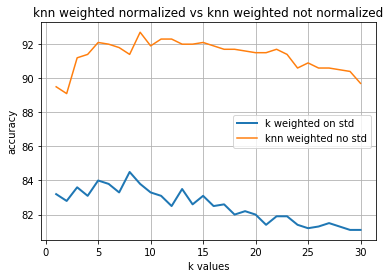

maximum accuracy is 84.5 at 7th run
the best k value is:8, and the accuracy is 84.5


In [29]:
k_ranges_weight_std=[]
accuracy_ranges_weight_std=[]
tic=time.time()
for k in range(1,31):
    y_test_predicted=[]
    print("="*50)
    print("knn calculating..... for k= {}".format(k))

    for element in tqdm(x_test):
        indexes,distances=calculateDistances(x_train, element)
        #print(distances.shape)
        indexes,distances=slice_k(k,indexes,distances)
        label=weighted_majority_vote(distances,indexes,y_train,1)
        y_test_predicted.append(label)

    y_test_predicted=np.asarray(y_test_predicted)##y_predicted is my predictions

    acc=accuracy_score(y_test,y_test_predicted)*100
    print("the accuracy value is :{}".format(acc))
    print("="*50)
    print("\n") 
    k_ranges_weight_std.append(k)
    accuracy_ranges_weight_std.append(acc)
    
toc=time.time()
print("time taken to evaluate is:{}".format(toc-tic))
print(accuracy_ranges_weight_std)
#plotting graphs with matplot lib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(k_ranges_weight_std, accuracy_ranges_weight_std, linewidth=2)
plt.plot(k_ranges_weight, accuracy_ranges_weight)
plt.legend(["k weighted on std","knn weighted no std"])
plt.axis('tight')
plt.grid()
plt.xlabel('k values')
plt.ylabel('accuracy')
plt.title("knn weighted normalized vs knn weighted not normalized")
plt.show()
ind=accuracy_ranges_weight_std.index(max(accuracy_ranges_weight_std))
print("maximum accuracy is {} at {}th run".format(max(accuracy_ranges_weight_std),ind))
best_k_weight_std=k_ranges_weight_std[ind]
print("the best k value is:{}, and the accuracy is {}".format(best_k_weight_std,accuracy_ranges_weight_std[ind]))

#the results have slightly less top accuracy without normalization.
#sometimes standardization helps to get better accuracy and sometimes it just fails,
#but it is a good practice to always apply normalization
#In our experimental analysis found execution time is 1 sec slower
#since it is normalized, we eliminate the large feature values that are dominating in euclidean distance measure but at the same time the feature value becomes float points and many float points can cause slower calculation


# can we test our results for weight penalizing the far distant points even more  let's try- 

In [23]:
from numpy import genfromtxt
my_data = genfromtxt('trainingData.csv', delimiter=',')

y_train=my_data[:,10]# this prints the labels
x_train=my_data[:,:-1] #every row except the last row until last col


print(x_train.shape)

my_data = genfromtxt('testData.csv', delimiter=',')

y_test=my_data[:,10]
x_test=my_data[:,:-1]

k_ranges_weight_std=[]
accuracy_ranges_weight_std=[]
n_ranges_std=[]
tic=time.time()
for k in range(1,31):
    for n in range(1,6):
        y_test_predicted=[]
        print("="*50)
        print("knn calculating..... for k= {} and n={}".format(k,n))

        for element in tqdm(x_test):
            indexes,distances=calculateDistances(x_train, element)
            #print(distances.shape)
            indexes,distances=slice_k(k,indexes,distances)
            label=weighted_majority_vote(distances,indexes,y_train,n)
            y_test_predicted.append(label)

        y_test_predicted=np.asarray(y_test_predicted)##y_predicted is my predictions

        acc=accuracy_score(y_test,y_test_predicted)*100
        print("the accuracy value is :{}".format(acc))
        print("="*50)
        print("\n") 
        k_ranges_weight_std.append(k)
        accuracy_ranges_weight_std.append(acc)
        n_ranges_std.append(n)
    
toc=time.time()
print("time taken to evaluate is:{}".format(toc-tic))
#print(accuracy_ranges_weight_std)
#plotting graphs with matplot lib


  6%|▌         | 62/1000 [00:00<00:01, 616.57it/s]

(4000, 10)
knn calculating..... for k= 1 and n=1


  6%|▌         | 61/1000 [00:00<00:01, 599.33it/s]

the accuracy value is :89.5


knn calculating..... for k= 1 and n=2


 13%|█▎        | 129/1000 [00:00<00:01, 645.05it/s]

the accuracy value is :89.5


knn calculating..... for k= 1 and n=3


  6%|▌         | 60/1000 [00:00<00:01, 597.24it/s]

the accuracy value is :89.5


knn calculating..... for k= 1 and n=4


  7%|▋         | 67/1000 [00:00<00:01, 664.34it/s]

the accuracy value is :89.5


knn calculating..... for k= 1 and n=5


 13%|█▎        | 129/1000 [00:00<00:01, 645.24it/s]

the accuracy value is :89.5


knn calculating..... for k= 2 and n=1


  6%|▋         | 65/1000 [00:00<00:01, 648.63it/s]

the accuracy value is :89.1


knn calculating..... for k= 2 and n=2


  6%|▌         | 61/1000 [00:00<00:01, 598.74it/s]

the accuracy value is :89.1


knn calculating..... for k= 2 and n=3


  6%|▋         | 65/1000 [00:00<00:01, 640.95it/s]

the accuracy value is :89.1


knn calculating..... for k= 2 and n=4


 12%|█▏        | 124/1000 [00:00<00:01, 622.52it/s]

the accuracy value is :89.1


knn calculating..... for k= 2 and n=5


 14%|█▎        | 136/1000 [00:00<00:01, 678.33it/s]

the accuracy value is :89.1


knn calculating..... for k= 3 and n=1


  6%|▌         | 62/1000 [00:00<00:01, 613.67it/s]

the accuracy value is :91.2


knn calculating..... for k= 3 and n=2


  6%|▌         | 61/1000 [00:00<00:01, 606.58it/s]

the accuracy value is :89.8


knn calculating..... for k= 3 and n=3


  6%|▌         | 58/1000 [00:00<00:01, 575.90it/s]

the accuracy value is :89.5


knn calculating..... for k= 3 and n=4


  6%|▌         | 62/1000 [00:00<00:01, 617.89it/s]

the accuracy value is :89.1


knn calculating..... for k= 3 and n=5


  6%|▌         | 60/1000 [00:00<00:01, 597.73it/s]

the accuracy value is :89.1


knn calculating..... for k= 4 and n=1


  7%|▋         | 66/1000 [00:00<00:01, 654.61it/s]

the accuracy value is :91.4


knn calculating..... for k= 4 and n=2


  6%|▌         | 62/1000 [00:00<00:01, 619.08it/s]

the accuracy value is :91.0


knn calculating..... for k= 4 and n=3


  7%|▋         | 66/1000 [00:00<00:01, 649.50it/s]

the accuracy value is :90.3


knn calculating..... for k= 4 and n=4


 13%|█▎        | 134/1000 [00:00<00:01, 661.61it/s]

the accuracy value is :90.2


knn calculating..... for k= 4 and n=5


  7%|▋         | 67/1000 [00:00<00:01, 655.14it/s]

the accuracy value is :89.8


knn calculating..... for k= 5 and n=1


 13%|█▎        | 126/1000 [00:00<00:01, 637.45it/s]

the accuracy value is :92.10000000000001


knn calculating..... for k= 5 and n=2


  6%|▌         | 61/1000 [00:00<00:01, 604.56it/s]

the accuracy value is :91.2


knn calculating..... for k= 5 and n=3


  6%|▌         | 62/1000 [00:00<00:01, 611.88it/s]

the accuracy value is :91.0


knn calculating..... for k= 5 and n=4


 12%|█▏        | 124/1000 [00:00<00:01, 606.36it/s]

the accuracy value is :90.10000000000001


knn calculating..... for k= 5 and n=5


  6%|▌         | 61/1000 [00:00<00:01, 608.31it/s]

the accuracy value is :89.7


knn calculating..... for k= 6 and n=1


  6%|▌         | 58/1000 [00:00<00:01, 572.24it/s]

the accuracy value is :92.0


knn calculating..... for k= 6 and n=2


  7%|▋         | 66/1000 [00:00<00:01, 653.83it/s]

the accuracy value is :91.5


knn calculating..... for k= 6 and n=3


  5%|▌         | 53/1000 [00:00<00:01, 521.96it/s]

the accuracy value is :90.2


knn calculating..... for k= 6 and n=4


  6%|▌         | 62/1000 [00:00<00:01, 610.10it/s]

the accuracy value is :89.60000000000001


knn calculating..... for k= 6 and n=5


  6%|▌         | 60/1000 [00:00<00:01, 599.83it/s]

the accuracy value is :89.1


knn calculating..... for k= 7 and n=1


  6%|▋         | 64/1000 [00:00<00:01, 637.31it/s]

the accuracy value is :91.8


knn calculating..... for k= 7 and n=2


  6%|▋         | 65/1000 [00:00<00:01, 648.53it/s]

the accuracy value is :91.5


knn calculating..... for k= 7 and n=3


  6%|▋         | 65/1000 [00:00<00:01, 647.92it/s]

the accuracy value is :90.10000000000001


knn calculating..... for k= 7 and n=4


  6%|▋         | 64/1000 [00:00<00:01, 634.83it/s]

the accuracy value is :89.5


knn calculating..... for k= 7 and n=5


  6%|▌         | 59/1000 [00:00<00:01, 586.47it/s]

the accuracy value is :89.2


knn calculating..... for k= 8 and n=1


  7%|▋         | 67/1000 [00:00<00:01, 662.46it/s]

the accuracy value is :91.4


knn calculating..... for k= 8 and n=2


  6%|▋         | 63/1000 [00:00<00:01, 624.32it/s]

the accuracy value is :91.3


knn calculating..... for k= 8 and n=3


  6%|▌         | 59/1000 [00:00<00:01, 589.87it/s]

the accuracy value is :90.4


knn calculating..... for k= 8 and n=4


  7%|▋         | 68/1000 [00:00<00:01, 677.16it/s]

the accuracy value is :89.3


knn calculating..... for k= 8 and n=5


  6%|▌         | 61/1000 [00:00<00:01, 602.27it/s]

the accuracy value is :89.1


knn calculating..... for k= 9 and n=1


 13%|█▎        | 134/1000 [00:00<00:01, 671.66it/s]

the accuracy value is :92.7


knn calculating..... for k= 9 and n=2


  6%|▌         | 61/1000 [00:00<00:01, 604.08it/s]

the accuracy value is :92.0


knn calculating..... for k= 9 and n=3


 12%|█▏        | 121/1000 [00:00<00:01, 600.94it/s]

the accuracy value is :90.9


knn calculating..... for k= 9 and n=4


  6%|▌         | 60/1000 [00:00<00:01, 595.25it/s]

the accuracy value is :90.4


knn calculating..... for k= 9 and n=5


  6%|▋         | 64/1000 [00:00<00:01, 637.71it/s]

the accuracy value is :89.8


knn calculating..... for k= 10 and n=1


  7%|▋         | 66/1000 [00:00<00:01, 655.97it/s]

the accuracy value is :91.9


knn calculating..... for k= 10 and n=2


  6%|▋         | 63/1000 [00:00<00:01, 624.62it/s]

the accuracy value is :91.4


knn calculating..... for k= 10 and n=3


  6%|▌         | 62/1000 [00:00<00:01, 613.18it/s]

the accuracy value is :91.0


knn calculating..... for k= 10 and n=4


  6%|▋         | 65/1000 [00:00<00:01, 646.57it/s]

the accuracy value is :89.9


knn calculating..... for k= 10 and n=5


  6%|▌         | 59/1000 [00:00<00:01, 585.76it/s]

the accuracy value is :89.2


knn calculating..... for k= 11 and n=1


  7%|▋         | 67/1000 [00:00<00:01, 665.52it/s]

the accuracy value is :92.30000000000001


knn calculating..... for k= 11 and n=2


  7%|▋         | 67/1000 [00:00<00:01, 666.28it/s]

the accuracy value is :91.9


knn calculating..... for k= 11 and n=3


  7%|▋         | 66/1000 [00:00<00:01, 655.79it/s]

the accuracy value is :90.8


knn calculating..... for k= 11 and n=4


  6%|▌         | 61/1000 [00:00<00:01, 606.27it/s]

the accuracy value is :89.8


knn calculating..... for k= 11 and n=5


  6%|▋         | 64/1000 [00:00<00:01, 631.95it/s]

the accuracy value is :89.2


knn calculating..... for k= 12 and n=1


  7%|▋         | 66/1000 [00:00<00:01, 657.14it/s]

the accuracy value is :92.30000000000001


knn calculating..... for k= 12 and n=2


  6%|▋         | 63/1000 [00:00<00:01, 623.49it/s]

the accuracy value is :92.30000000000001


knn calculating..... for k= 12 and n=3


  6%|▌         | 60/1000 [00:00<00:01, 594.96it/s]

the accuracy value is :91.3


knn calculating..... for k= 12 and n=4


  6%|▌         | 62/1000 [00:00<00:01, 613.21it/s]

the accuracy value is :90.0


knn calculating..... for k= 12 and n=5


  7%|▋         | 69/1000 [00:00<00:01, 683.73it/s]

the accuracy value is :88.9


knn calculating..... for k= 13 and n=1


  7%|▋         | 68/1000 [00:00<00:01, 674.98it/s]

the accuracy value is :92.0


knn calculating..... for k= 13 and n=2


  7%|▋         | 68/1000 [00:00<00:01, 677.41it/s]

the accuracy value is :91.9


knn calculating..... for k= 13 and n=3


  7%|▋         | 68/1000 [00:00<00:01, 675.57it/s]

the accuracy value is :91.3


knn calculating..... for k= 13 and n=4


  6%|▌         | 62/1000 [00:00<00:01, 617.21it/s]

the accuracy value is :90.10000000000001


knn calculating..... for k= 13 and n=5


  6%|▋         | 63/1000 [00:00<00:01, 623.26it/s]

the accuracy value is :88.9


knn calculating..... for k= 14 and n=1


  6%|▌         | 62/1000 [00:00<00:01, 618.60it/s]

the accuracy value is :92.0


knn calculating..... for k= 14 and n=2


  6%|▌         | 59/1000 [00:00<00:01, 585.03it/s]

the accuracy value is :92.10000000000001


knn calculating..... for k= 14 and n=3


 12%|█▏        | 123/1000 [00:00<00:01, 615.41it/s]

the accuracy value is :91.7


knn calculating..... for k= 14 and n=4


  6%|▌         | 61/1000 [00:00<00:01, 609.55it/s]

the accuracy value is :90.3


knn calculating..... for k= 14 and n=5


 12%|█▏        | 124/1000 [00:00<00:01, 622.45it/s]

the accuracy value is :89.4


knn calculating..... for k= 15 and n=1


  6%|▌         | 61/1000 [00:00<00:01, 606.24it/s]

the accuracy value is :92.10000000000001


knn calculating..... for k= 15 and n=2


  6%|▌         | 60/1000 [00:00<00:01, 597.31it/s]

the accuracy value is :91.7


knn calculating..... for k= 15 and n=3


  6%|▋         | 63/1000 [00:00<00:01, 628.29it/s]

the accuracy value is :91.7


knn calculating..... for k= 15 and n=4


  6%|▌         | 57/1000 [00:00<00:01, 566.28it/s]

the accuracy value is :90.5


knn calculating..... for k= 15 and n=5


  6%|▋         | 64/1000 [00:00<00:01, 639.23it/s]

the accuracy value is :89.60000000000001


knn calculating..... for k= 16 and n=1


  6%|▌         | 62/1000 [00:00<00:01, 615.20it/s]

the accuracy value is :91.9


knn calculating..... for k= 16 and n=2


 13%|█▎        | 133/1000 [00:00<00:01, 660.09it/s]

the accuracy value is :92.0


knn calculating..... for k= 16 and n=3


  6%|▋         | 63/1000 [00:00<00:01, 624.00it/s]

the accuracy value is :91.4


knn calculating..... for k= 16 and n=4


  6%|▌         | 62/1000 [00:00<00:01, 617.10it/s]

the accuracy value is :90.60000000000001


knn calculating..... for k= 16 and n=5


  7%|▋         | 66/1000 [00:00<00:01, 654.77it/s]

the accuracy value is :89.60000000000001


knn calculating..... for k= 17 and n=1


  6%|▌         | 60/1000 [00:00<00:01, 599.60it/s]

the accuracy value is :91.7


knn calculating..... for k= 17 and n=2


  6%|▌         | 61/1000 [00:00<00:01, 607.31it/s]

the accuracy value is :91.4


knn calculating..... for k= 17 and n=3


  7%|▋         | 66/1000 [00:00<00:01, 655.69it/s]

the accuracy value is :91.10000000000001


knn calculating..... for k= 17 and n=4


  7%|▋         | 67/1000 [00:00<00:01, 667.09it/s]

the accuracy value is :90.60000000000001


knn calculating..... for k= 17 and n=5


 12%|█▎        | 125/1000 [00:00<00:01, 619.60it/s]

the accuracy value is :89.60000000000001


knn calculating..... for k= 18 and n=1


  6%|▋         | 63/1000 [00:00<00:01, 623.93it/s]

the accuracy value is :91.7


knn calculating..... for k= 18 and n=2


  6%|▌         | 62/1000 [00:00<00:01, 610.39it/s]

the accuracy value is :91.60000000000001


knn calculating..... for k= 18 and n=3


  6%|▌         | 62/1000 [00:00<00:01, 617.21it/s]

the accuracy value is :91.2


knn calculating..... for k= 18 and n=4


  6%|▋         | 64/1000 [00:00<00:01, 636.70it/s]

the accuracy value is :90.9


knn calculating..... for k= 18 and n=5


  6%|▋         | 64/1000 [00:00<00:01, 635.28it/s]

the accuracy value is :90.3


knn calculating..... for k= 19 and n=1


  4%|▍         | 44/1000 [00:00<00:02, 433.56it/s]

the accuracy value is :91.60000000000001


knn calculating..... for k= 19 and n=2


  7%|▋         | 66/1000 [00:00<00:01, 658.30it/s]

the accuracy value is :91.8


knn calculating..... for k= 19 and n=3


  6%|▌         | 60/1000 [00:00<00:01, 594.74it/s]

the accuracy value is :91.4


knn calculating..... for k= 19 and n=4


  6%|▌         | 56/1000 [00:00<00:01, 557.84it/s]

the accuracy value is :91.0


knn calculating..... for k= 19 and n=5


  7%|▋         | 67/1000 [00:00<00:01, 669.71it/s]

the accuracy value is :90.10000000000001


knn calculating..... for k= 20 and n=1


  6%|▋         | 65/1000 [00:00<00:01, 641.46it/s]

the accuracy value is :91.5


knn calculating..... for k= 20 and n=2


 13%|█▎        | 126/1000 [00:00<00:01, 633.94it/s]

the accuracy value is :91.3


knn calculating..... for k= 20 and n=3


  7%|▋         | 67/1000 [00:00<00:01, 661.79it/s]

the accuracy value is :91.4


knn calculating..... for k= 20 and n=4


 13%|█▎        | 126/1000 [00:00<00:01, 630.95it/s]

the accuracy value is :90.60000000000001


knn calculating..... for k= 20 and n=5


  6%|▋         | 64/1000 [00:00<00:01, 631.81it/s]

the accuracy value is :90.0


knn calculating..... for k= 21 and n=1


  7%|▋         | 66/1000 [00:00<00:01, 651.77it/s]

the accuracy value is :91.5


knn calculating..... for k= 21 and n=2


  6%|▌         | 62/1000 [00:00<00:01, 618.56it/s]

the accuracy value is :91.0


knn calculating..... for k= 21 and n=3


  7%|▋         | 67/1000 [00:00<00:01, 661.13it/s]

the accuracy value is :91.10000000000001


knn calculating..... for k= 21 and n=4


 13%|█▎        | 134/1000 [00:00<00:01, 667.06it/s]

the accuracy value is :90.2


knn calculating..... for k= 21 and n=5


  7%|▋         | 67/1000 [00:00<00:01, 667.54it/s]

the accuracy value is :89.9


knn calculating..... for k= 22 and n=1


  7%|▋         | 68/1000 [00:00<00:01, 674.94it/s]

the accuracy value is :91.7


knn calculating..... for k= 22 and n=2


  6%|▌         | 62/1000 [00:00<00:01, 618.72it/s]

the accuracy value is :91.2


knn calculating..... for k= 22 and n=3


  7%|▋         | 68/1000 [00:00<00:01, 673.52it/s]

the accuracy value is :90.9


knn calculating..... for k= 22 and n=4


  7%|▋         | 66/1000 [00:00<00:01, 650.41it/s]

the accuracy value is :90.10000000000001


knn calculating..... for k= 22 and n=5


  6%|▋         | 63/1000 [00:00<00:01, 621.37it/s]

the accuracy value is :89.8


knn calculating..... for k= 23 and n=1


  6%|▌         | 59/1000 [00:00<00:01, 584.84it/s]

the accuracy value is :91.4


knn calculating..... for k= 23 and n=2


  7%|▋         | 68/1000 [00:00<00:01, 674.83it/s]

the accuracy value is :90.9


knn calculating..... for k= 23 and n=3


  7%|▋         | 67/1000 [00:00<00:01, 666.68it/s]

the accuracy value is :91.0


knn calculating..... for k= 23 and n=4


  7%|▋         | 68/1000 [00:00<00:01, 670.65it/s]

the accuracy value is :89.9


knn calculating..... for k= 23 and n=5


 13%|█▎        | 132/1000 [00:00<00:01, 657.56it/s]

the accuracy value is :88.9


knn calculating..... for k= 24 and n=1


  7%|▋         | 66/1000 [00:00<00:01, 653.53it/s]

the accuracy value is :90.60000000000001


knn calculating..... for k= 24 and n=2


  6%|▌         | 60/1000 [00:00<00:01, 594.03it/s]

the accuracy value is :90.4


knn calculating..... for k= 24 and n=3


  7%|▋         | 68/1000 [00:00<00:01, 673.85it/s]

the accuracy value is :90.60000000000001


knn calculating..... for k= 24 and n=4


  7%|▋         | 68/1000 [00:00<00:01, 668.69it/s]

the accuracy value is :90.0


knn calculating..... for k= 24 and n=5


  6%|▋         | 63/1000 [00:00<00:01, 622.71it/s]

the accuracy value is :89.0


knn calculating..... for k= 25 and n=1


  6%|▋         | 64/1000 [00:00<00:01, 634.68it/s]

the accuracy value is :90.9


knn calculating..... for k= 25 and n=2


  7%|▋         | 68/1000 [00:00<00:01, 672.50it/s]

the accuracy value is :90.3


knn calculating..... for k= 25 and n=3


  6%|▋         | 64/1000 [00:00<00:01, 621.82it/s]

the accuracy value is :90.4


knn calculating..... for k= 25 and n=4


  7%|▋         | 67/1000 [00:00<00:01, 664.77it/s]

the accuracy value is :89.8


knn calculating..... for k= 25 and n=5


 13%|█▎        | 131/1000 [00:00<00:01, 652.28it/s]

the accuracy value is :89.1


knn calculating..... for k= 26 and n=1


 13%|█▎        | 126/1000 [00:00<00:01, 608.85it/s]

the accuracy value is :90.60000000000001


knn calculating..... for k= 26 and n=2


 13%|█▎        | 128/1000 [00:00<00:01, 622.97it/s]

the accuracy value is :90.7


knn calculating..... for k= 26 and n=3


 13%|█▎        | 133/1000 [00:00<00:01, 653.07it/s]

the accuracy value is :90.3


knn calculating..... for k= 26 and n=4


  6%|▌         | 62/1000 [00:00<00:01, 611.05it/s]

the accuracy value is :89.7


knn calculating..... for k= 26 and n=5


  7%|▋         | 68/1000 [00:00<00:01, 679.55it/s]

the accuracy value is :88.8


knn calculating..... for k= 27 and n=1


  6%|▌         | 60/1000 [00:00<00:01, 598.38it/s]

the accuracy value is :90.60000000000001


knn calculating..... for k= 27 and n=2


  7%|▋         | 67/1000 [00:00<00:01, 669.38it/s]

the accuracy value is :89.7


knn calculating..... for k= 27 and n=3


 14%|█▎        | 135/1000 [00:00<00:01, 669.53it/s]

the accuracy value is :89.7


knn calculating..... for k= 27 and n=4


  7%|▋         | 68/1000 [00:00<00:01, 672.34it/s]

the accuracy value is :89.4


knn calculating..... for k= 27 and n=5


  6%|▋         | 65/1000 [00:00<00:01, 642.39it/s]

the accuracy value is :87.9


knn calculating..... for k= 28 and n=1


  6%|▌         | 62/1000 [00:00<00:01, 612.04it/s]

the accuracy value is :90.5


knn calculating..... for k= 28 and n=2


  7%|▋         | 67/1000 [00:00<00:01, 660.36it/s]

the accuracy value is :90.2


knn calculating..... for k= 28 and n=3


 12%|█▎        | 125/1000 [00:00<00:01, 612.48it/s]

the accuracy value is :90.10000000000001


knn calculating..... for k= 28 and n=4


  7%|▋         | 66/1000 [00:00<00:01, 659.37it/s]

the accuracy value is :89.1


knn calculating..... for k= 28 and n=5


  6%|▋         | 63/1000 [00:00<00:01, 624.20it/s]

the accuracy value is :88.3


knn calculating..... for k= 29 and n=1


  7%|▋         | 66/1000 [00:00<00:01, 657.52it/s]

the accuracy value is :90.4


knn calculating..... for k= 29 and n=2


 13%|█▎        | 126/1000 [00:00<00:01, 634.96it/s]

the accuracy value is :90.10000000000001


knn calculating..... for k= 29 and n=3


 12%|█▏        | 121/1000 [00:00<00:01, 595.38it/s]

the accuracy value is :90.10000000000001


knn calculating..... for k= 29 and n=4


  7%|▋         | 67/1000 [00:00<00:01, 660.41it/s]

the accuracy value is :89.2


knn calculating..... for k= 29 and n=5


  7%|▋         | 68/1000 [00:00<00:01, 674.64it/s]

the accuracy value is :88.4


knn calculating..... for k= 30 and n=1


 13%|█▎        | 132/1000 [00:00<00:01, 655.06it/s]

the accuracy value is :89.7


knn calculating..... for k= 30 and n=2


  6%|▌         | 59/1000 [00:00<00:01, 588.78it/s]

the accuracy value is :89.7


knn calculating..... for k= 30 and n=3


  7%|▋         | 68/1000 [00:00<00:01, 675.55it/s]

the accuracy value is :89.7


knn calculating..... for k= 30 and n=4


 14%|█▎        | 135/1000 [00:00<00:01, 671.20it/s]

the accuracy value is :89.1


knn calculating..... for k= 30 and n=5


100%|██████████| 1000/1000 [00:01<00:00, 629.20it/s]

the accuracy value is :87.8


time taken to evaluate is:239.97605800628662


92.7


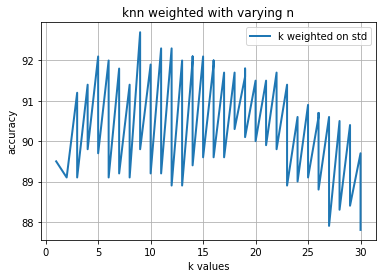

maximum accuracy is 92.7 at 40th run
the best k value is:9, and the accuracy is 92.7


In [25]:
print(max(accuracy_ranges_weight_std))
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(k_ranges_weight_std, accuracy_ranges_weight_std, linewidth=2)
plt.legend(["k weighted on std","knn weighted no std"])
plt.axis('tight')
plt.grid()
plt.xlabel('k values')
plt.ylabel('accuracy')
plt.title("knn weighted with varying n")
plt.show()
ind=accuracy_ranges_weight_std.index(max(accuracy_ranges_weight_std))
print("maximum accuracy is {} at {}th run".format(max(accuracy_ranges_weight_std),ind))
best_k_weight_std=k_ranges_weight_std[ind]
print("the best k value is:{}, and the accuracy is {}".format(best_k_weight_std,accuracy_ranges_weight_std[ind]))

the oscillation below clearly shows that my value is maximum for n=1 and then falls down as i keep penalizing my large distance, at some point the model becomes extremly biased towards it.

Hence, this is not helping us acheive the goal so varying n does not improve the accuracy only worsens it

In [19]:
#lets try for various distance measures in minkowski power 
#1- manhattan #2-euclidean

k_ranges_weight_std=[]
accuracy_ranges_weight_std=[]
tic=time.time()
for k in range(1,5):
    for p in range(1,8):
        y_test_predicted=[]
        print("="*50)
        print("knn calculating..... for k= {} and p={}".format(k,p))
        for element in tqdm(x_test):
            indexes,distances=calculateDistances(x_train, element,p)
            #print(distances.shape)
            indexes,distances=slice_k(k,indexes,distances)
            label=weighted_majority_vote(distances,indexes,y_train,n)
            y_test_predicted.append(label)
        y_test_predicted=np.asarray(y_test_predicted)##y_predicted is my predictions

        acc=accuracy_score(y_test,y_test_predicted)*100
        print("the accuracy value is :{}".format(acc))
        print("="*50)
        print("\n") 
        k_ranges_weight_std.append(k)
        accuracy_ranges_weight_std.append(acc)
    
toc=time.time()
print("time taken to evaluate is:{}".format(toc-tic))
print(accuracy_ranges_weight_std)
#plotting graphs with matplot lib

#clearly increasing the power of the minkowski metric does not help however an interesting behaviour is seen when
#the powers are in even they still hold some values but not when they are odd.




  0%|          | 0/1000 [00:00<?, ?it/s]

knn calculating..... for k= 1 and p=1


  6%|▌         | 61/1000 [00:00<00:01, 604.04it/s]

the accuracy value is :49.8


knn calculating..... for k= 1 and p=2


  6%|▋         | 65/1000 [00:00<00:01, 640.62it/s]

the accuracy value is :89.5


knn calculating..... for k= 1 and p=3


  6%|▋         | 65/1000 [00:00<00:01, 639.64it/s]

the accuracy value is :46.800000000000004


knn calculating..... for k= 1 and p=4


  6%|▋         | 63/1000 [00:00<00:01, 625.18it/s]

the accuracy value is :88.8


knn calculating..... for k= 1 and p=5


  7%|▋         | 67/1000 [00:00<00:01, 660.84it/s]

the accuracy value is :49.0


knn calculating..... for k= 1 and p=6


  7%|▋         | 70/1000 [00:00<00:01, 699.51it/s]

the accuracy value is :88.9


knn calculating..... for k= 1 and p=7


  8%|▊         | 81/1000 [00:00<00:01, 805.71it/s]

the accuracy value is :52.400000000000006


knn calculating..... for k= 2 and p=1


 13%|█▎        | 131/1000 [00:00<00:01, 651.94it/s]

the accuracy value is :40.699999999999996


knn calculating..... for k= 2 and p=2


  7%|▋         | 72/1000 [00:00<00:01, 715.74it/s]

the accuracy value is :89.1


knn calculating..... for k= 2 and p=3


 14%|█▎        | 137/1000 [00:00<00:01, 681.75it/s]

the accuracy value is :45.9


knn calculating..... for k= 2 and p=4


 14%|█▍        | 143/1000 [00:00<00:01, 708.33it/s]

the accuracy value is :88.6


knn calculating..... for k= 2 and p=5


  7%|▋         | 68/1000 [00:00<00:01, 677.22it/s]

the accuracy value is :48.0


knn calculating..... for k= 2 and p=6


  6%|▋         | 63/1000 [00:00<00:01, 628.61it/s]

the accuracy value is :88.2


knn calculating..... for k= 2 and p=7


  8%|▊         | 79/1000 [00:00<00:01, 787.54it/s]

the accuracy value is :52.2


knn calculating..... for k= 3 and p=1


 13%|█▎        | 126/1000 [00:00<00:01, 636.47it/s]

the accuracy value is :43.4


knn calculating..... for k= 3 and p=2


  7%|▋         | 66/1000 [00:00<00:01, 650.16it/s]

the accuracy value is :89.1


knn calculating..... for k= 3 and p=3


  6%|▌         | 62/1000 [00:00<00:01, 611.91it/s]

the accuracy value is :44.9


knn calculating..... for k= 3 and p=4


  6%|▋         | 65/1000 [00:00<00:01, 640.57it/s]

the accuracy value is :89.60000000000001


knn calculating..... for k= 3 and p=5


  6%|▌         | 61/1000 [00:00<00:01, 606.02it/s]

the accuracy value is :49.0


knn calculating..... for k= 3 and p=6


  6%|▌         | 59/1000 [00:00<00:01, 585.26it/s]

the accuracy value is :89.1


knn calculating..... for k= 3 and p=7


 17%|█▋        | 170/1000 [00:00<00:00, 843.51it/s]

the accuracy value is :49.7


knn calculating..... for k= 4 and p=1


  6%|▋         | 64/1000 [00:00<00:01, 638.41it/s]

the accuracy value is :39.4


knn calculating..... for k= 4 and p=2


  7%|▋         | 69/1000 [00:00<00:01, 677.95it/s]

the accuracy value is :89.8


knn calculating..... for k= 4 and p=3


  7%|▋         | 68/1000 [00:00<00:01, 676.92it/s]

the accuracy value is :43.9


knn calculating..... for k= 4 and p=4


  7%|▋         | 69/1000 [00:00<00:01, 680.70it/s]

the accuracy value is :89.7


knn calculating..... for k= 4 and p=5


  7%|▋         | 68/1000 [00:00<00:01, 673.26it/s]

the accuracy value is :44.7


knn calculating..... for k= 4 and p=6


  7%|▋         | 68/1000 [00:00<00:01, 673.87it/s]

the accuracy value is :89.7


knn calculating..... for k= 4 and p=7


100%|██████████| 1000/1000 [00:01<00:00, 685.09it/s]

the accuracy value is :43.2


time taken to evaluate is:41.90811491012573
[49.8, 89.5, 46.800000000000004, 88.8, 49.0, 88.9, 52.400000000000006, 40.699999999999996, 89.1, 45.9, 88.6, 48.0, 88.2, 52.2, 43.4, 89.1, 44.9, 89.60000000000001, 49.0, 89.1, 49.7, 39.4, 89.8, 43.9, 89.7, 44.7, 89.7, 43.2]


92.7
10


[]
